# Importiere Daten


In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import datetime
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import bootstrap
import os as os
import seaborn as sns

## Funktionen definieren

In [2]:
def linear_reg(x, m, t):
    return m*x + t

def generate_cosine_weight(angles):
    temp = np.cos(np.radians(angles))
    cosine_values = temp/np.sum(temp)
    return cosine_values

def weigth(arr):
    return np.multiply(generate_cosine_weight(arr['lat'].values), arr)

In [3]:
month_label = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]

legend_colors = plt.cm.tab20(range(12))

In [4]:
custom_rc_params_small = {
    'figure.figsize': (8.5, 5),  # Width x Height in centimeters
    'font.size': 12,  # Font size
    # You can add more custom parameters here if needed
}

plt.rcParams.update(custom_rc_params_small)

## Daten importieren

In [5]:
TMin_file = 'C:/Users/leonh/Desktop/Praktikum_AWI/data/cru_ts4.07.1901.2022.tmn.dat.nc/cru_ts4.07.1901.2022.tmn.dat.nc'
TMax_file = 'C:/Users/leonh/Desktop/Praktikum_AWI/data/cru_ts4.07.1901.2022.tmx.dat.nc/cru_ts4.07.1901.2022.tmx.dat.nc'
TAvg_file = 'C:/Users/leonh/Desktop/Praktikum_AWI/data/cru_ts4.07.1901.2022.tmp.dat.nc/cru_ts4.07.1901.2022.tmp.dat.nc'



TMin = xr.open_dataset(TMin_file)
TMax = xr.open_dataset(TMax_file)
TAvg = xr.open_dataset(TAvg_file)


In [6]:
# TMin = TMin.sel(lat = slice(0,90))
# TMax = TMax.sel(lat = slice(0,90))
# TAvg = TAvg.sel(lat = slice(0,90))

## Differenz berechnen

In [7]:
DTR = TMax.tmx.sel(time = slice(pd.to_datetime('1969'), pd.to_datetime('2023'))) - TMin.tmn.sel(time = slice(pd.to_datetime('1969'), pd.to_datetime('2023')))
TAvg_time = TAvg.tmp.sel(time = slice(pd.to_datetime('1969'), pd.to_datetime('2023'))).mean('time') #lat = slice(70,84), 

In [8]:
# #Alternative

# DTR = TMax.tmx.sel(time = slice(pd.to_datetime('1985'), pd.to_datetime('2023'))) - TMin.tmn.sel(time = slice(pd.to_datetime('1969'), pd.to_datetime('2023')))
# TAvg_time = TAvg.tmp.sel(time = slice(pd.to_datetime('1985'), pd.to_datetime('2023'))).mean('time') #lat = slice(70,84), 


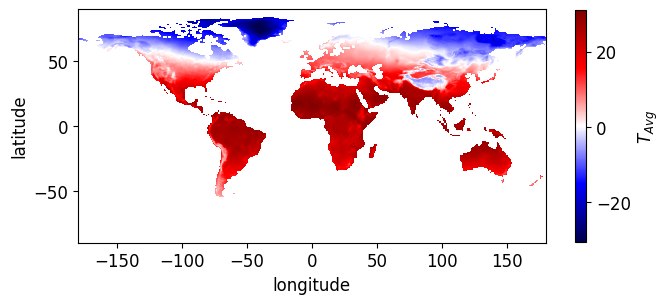

In [9]:
x_coords = TAvg_time.coords['lon'].values  # Replace 'your_x_coordinate' with the actual coordinate name
y_coords = TAvg_time.coords['lat'].values  # Replace 'your_y_coordinate' with the actual coordinate name

# Create a heatmap using Matplotlib
plt.figure(figsize=(17/2.46, 5.5))
heatmap = plt.imshow(TAvg_time, cmap='seismic', origin='lower', extent=[x_coords.min(), x_coords.max(), y_coords.min(), y_coords.max()])

cbar = plt.colorbar(heatmap, shrink=0.45, label='$T_{Avg}$')
#plt.title('$T_{Avg}$')
plt.xlabel('longitude')
plt.ylabel('latitude')

plt.tight_layout()
plt.show()

In [10]:
d = 3  # Adjust this value to your desired interval length

# Create bins for the 'x' values
TAvg_time_bin = ((TAvg_time// d) * d).copy()

TAvg_time_bin = TAvg_time_bin.rename('bin')

TAvg_time_combined = xr.merge([TAvg_time, TAvg_time_bin])

print(TAvg_time_combined)

unique_bins = xr.DataArray(np.unique(TAvg_time_combined['bin']), dims='bin', name='unique_bins')[:-1]

# unique_bins


<xarray.Dataset>
Dimensions:  (lon: 720, lat: 360)
Coordinates:
  * lon      (lon) float32 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float32 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
Data variables:
    tmp      (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    bin      (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan


## Mask

In [11]:
# TAvg_mask_dict = {}
# for i in unique_bins:
#     TAvg_mask_dict = TAvg_mask_dict + {str(i): (TAvg_time_combined[bin] == i)}

TAvg_mask_dict = {}
for i in list(unique_bins.values):
    TAvg_mask_dict[str(i)] = (TAvg_time_combined.bin == i)
    print(str(i))


-33.0
-30.0
-27.0
-24.0
-21.0
-18.0
-15.0
-12.0
-9.0
-6.0
-3.0
0.0
3.0
6.0
9.0
12.0
15.0
18.0
21.0
24.0
27.0
30.0


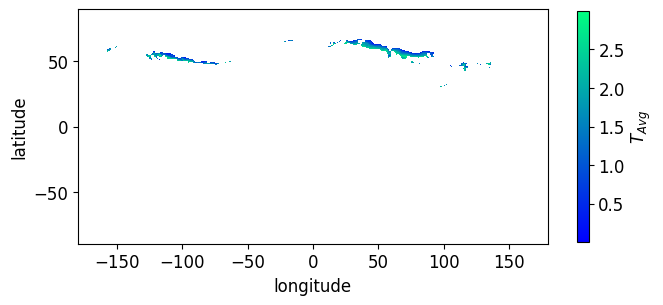

[3.0841652e-04 1.6974086e-03 1.6974357e-03 ... 2.9989212e+00 2.9998460e+00
           nan]


In [12]:
TAvg_mask_dict


x_coords = TAvg_time.where(TAvg_mask_dict['0.0']).coords['lon'].values  # Replace 'your_x_coordinate' with the actual coordinate name
y_coords = TAvg_time.where(TAvg_mask_dict['0.0']).coords['lat'].values  # Replace 'your_y_coordinate' with the actual coordinate name


# Create a heatmap using Matplotlib
plt.figure(figsize=(17/2.46, 5.5))
heatmap = plt.imshow(TAvg_time.where(TAvg_mask_dict['0.0']), cmap='winter', origin='lower', extent=[x_coords.min(), x_coords.max(), y_coords.min(), y_coords.max()])

cbar = plt.colorbar(heatmap, shrink=0.45, label='$T_{Avg}$')
#plt.title('$T_{Avg}$')
plt.xlabel('longitude')
plt.ylabel('latitude')

plt.tight_layout()
plt.show()

print(np.unique(TAvg_time.where(TAvg_mask_dict['0.0'])))


## Create Means

In [13]:
DTR_binned_timeseries = {}
    
for i in list(unique_bins.values):
    DTR_binned_timeseries[str(i)] = DTR.where(TAvg_mask_dict[str(i)]).mean(dim=['lat', 'lon'])
    print(str(i))

-33.0
-30.0
-27.0
-24.0
-21.0
-18.0
-15.0
-12.0
-9.0
-6.0
-3.0
0.0
3.0
6.0
9.0
12.0
15.0
18.0
21.0
24.0
27.0
30.0


In [14]:
# DTR_binned_timeseries['-45.0'].head()

In [15]:
monthly_DTR_per_bin_dict = {}
for i in list(unique_bins.values):
    monthly_mean_DTR_dict = {}
    for month in range(1, 13):
        # Slice the DataArray for the current month
        month_data = DTR_binned_timeseries[str(i)].where(DTR_binned_timeseries[str(i)]['time.month'] == month, drop=True)
        
        # Add the sliced DataArray to the dictionary with the month as the key
        monthly_mean_DTR_dict[month] = month_data
    
    monthly_DTR_per_bin_dict[str(i)] = monthly_mean_DTR_dict.copy()

In [16]:
# Create lists to store legend handles
legend_handles = []

# Create lists to store regression coefficients and R-squared values
regression_coeffs = []
r_squared_values = []

# startdate = pd.to_datetime('1973-01-01')
# enddate = pd.to_datetime('2023-01-01')
index = '0.0'

DTR_trend_month_dict = {}
for index in list(unique_bins.values):
    regression_coeffs = []
    for i in range(1, 13):
        #color = legend_colors[i - 1]
        # Filter the data for the specified date range (1960-01-01 to 1980-12-31)
        
        
        x = np.arange(len(monthly_DTR_per_bin_dict[str(index)][i]['time']))  # Use an index as x values
        y = monthly_DTR_per_bin_dict[str(index)][i]

        # Fit a linear regression line
        slope, intercept = np.polyfit(x, y, 1)
        
        # Calculate R-squared
        residuals = y - (slope * x + intercept)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        r_squared = 1 - (ss_res / ss_tot)

        # Plot the scatter plot
        #plt.scatter(monthly_DTR_per_bin_dict[str(index)][i]['time'], y, marker='x', color=color, label= month_label[i-1])
        
        # Plot the regression line
        #plt.plot(monthly_DTR_per_bin_dict[str(index)][i]['time'], slope * x + intercept, color=color, linestyle='--', alpha  = 0.5)

        # Create a dummy scatter plot with no markers to represent the legend
        #legend_handles.append(plt.scatter([], [], marker='.', color=color))

        # Append regression coefficients and R-squared values to lists
        regression_coeffs.append(slope)
        r_squared_values.append(r_squared)

    DTR_trend_month_dict[str(index)] = regression_coeffs.copy()



In [17]:
print(unique_bins.values)

[-33. -30. -27. -24. -21. -18. -15. -12.  -9.  -6.  -3.   0.   3.   6.
   9.  12.  15.  18.  21.  24.  27.  30.]


[-0.00064274  0.00401449  0.00154147 -0.00105226 -0.00334373  0.00239158
  0.00733735 -0.00026347 -0.00594371 -0.00057634 -0.00125669  0.00108134]


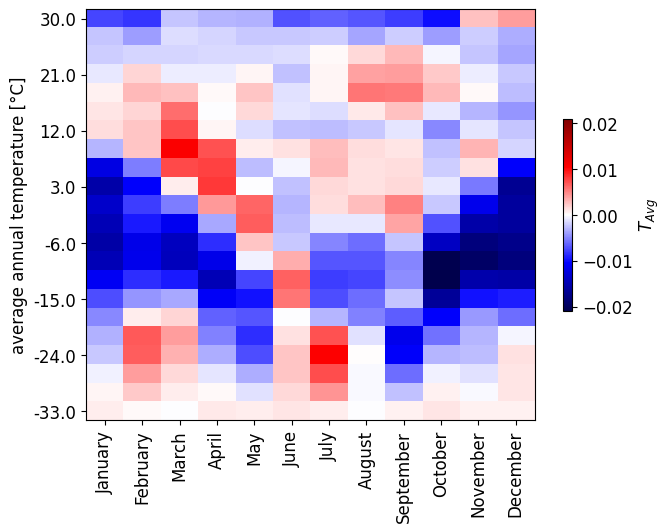

In [18]:
# Convert the dictionary of lists to a NumPy array
slope_array = np.array([values for values in DTR_trend_month_dict.values()])

print((slope_array[2]))

# x_coords = TAvg_time.where(TAvg_mask_dict['0.0']).coords['lon'].values  # Replace 'your_x_coordinate' with the actual coordinate name
# y_coords = TAvg_time.where(TAvg_mask_dict['0.0']).coords['lat'].values  # Replace 'your_y_coordinate' with the actual coordinate name

boundary = np.max([slope_array.max(), np.abs(slope_array.min())])

# Create a heatmap using Matplotlib
plt.figure(figsize=(17/2.46, 5.5))
heatmap = plt.imshow(slope_array, cmap='seismic', origin='lower',vmin= -boundary, vmax=boundary, aspect=0.5) #, extent=[x_coords.min(), x_coords.max(), y_coords.min(), y_coords.max()])

cbar = plt.colorbar(heatmap, shrink=0.45, label='$T_{Avg}$')
plt.xticks(np.arange(12), month_label, rotation='vertical')
plt.yticks(np.arange(slope_array.shape[0])[::3], unique_bins.values[::3])#, rotation='vertical')
#plt.title('$T_{Avg}$')
# plt.xlabel('average temperature [°C]')
plt.ylabel('average annual temperature [°C]')


plt.tight_layout()
plt.savefig('binned_trends_heatmap.pdf')
plt.show()

In [19]:
# # Convert the dictionary of lists to a NumPy array
# slope_array = np.array([values for values in DTR_trend_month_dict.values()])

# print((slope_array[2]))

# # x_coords = TAvg_time.where(TAvg_mask_dict['0.0']).coords['lon'].values  # Replace 'your_x_coordinate' with the actual coordinate name
# # y_coords = TAvg_time.where(TAvg_mask_dict['0.0']).coords['lat'].values  # Replace 'your_y_coordinate' with the actual coordinate name

# boundary = np.max([slope_array.max(), np.abs(slope_array.min())])

# # Create a heatmap using Matplotlib
# plt.figure(figsize=(17/2.46, 5.5))
# heatmap = plt.imshow(slope_array, cmap='seismic', origin='lower',vmin= -boundary, vmax=boundary, aspect=1) #, extent=[x_coords.min(), x_coords.max(), y_coords.min(), y_coords.max()])

# cbar = plt.colorbar(heatmap, shrink=0.45, label='$T_{Avg}$')
# plt.xticks(np.arange(12), month_label, rotation='vertical')
# plt.yticks(np.arange(6, 17)[::2], range(-15,16, 3)[::2])#, rotation='vertical')
# #plt.title('$T_{Avg}$')
# plt.ylim((-15, 15))
# # plt.xlabel('average temperature [°C]')
# plt.ylabel('average annual temperature [°C]')


# plt.tight_layout()
# #plt.savefig('binned_trends_heatmap.pdf')
# plt.show()

[-0.00064274  0.00401449  0.00154147 -0.00105226 -0.00334373  0.00239158
  0.00733735 -0.00026347 -0.00594371 -0.00057634 -0.00125669  0.00108134]


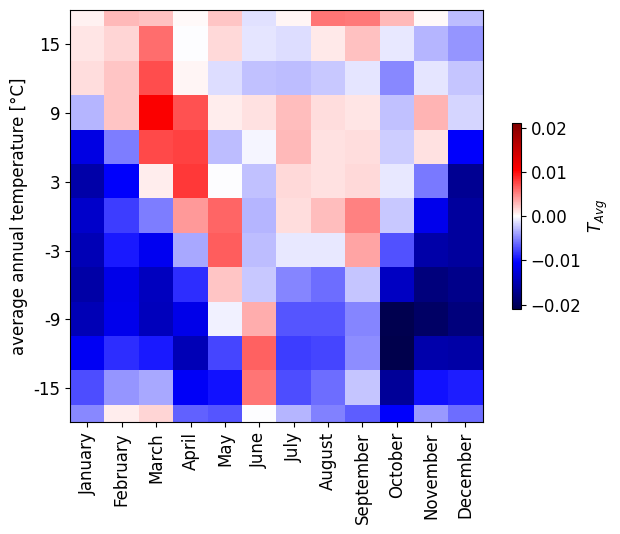

In [20]:
# Convert the dictionary of lists to a NumPy array
slope_array = np.array([values for values in DTR_trend_month_dict.values()])

print((slope_array[2]))

# x_coords = TAvg_time.where(TAvg_mask_dict['0.0']).coords['lon'].values  # Replace 'your_x_coordinate' with the actual coordinate name
# y_coords = TAvg_time.where(TAvg_mask_dict['0.0']).coords['lat'].values  # Replace 'your_y_coordinate' with the actual coordinate name

boundary = np.max([slope_array.max(), np.abs(slope_array.min())])

# Create a heatmap using Matplotlib
plt.figure(figsize=(17/2.46, 5.5))
heatmap = plt.imshow(slope_array, cmap='seismic', origin='lower', vmin=-boundary, vmax=boundary, aspect=1) #, extent=[x_coords.min(), x_coords.max(), y_coords.min(), y_coords.max()])

cbar = plt.colorbar(heatmap, shrink=0.45, label='$T_{Avg}$')
plt.xticks(np.arange(12), month_label, rotation='vertical')
plt.yticks(np.arange(6, 17)[::2], range(-15, 16, 3)[::2])  #, rotation='vertical')
#plt.title('$T_{Avg}$')
plt.ylim((5, 17))
# plt.xlabel('average temperature [°C]')
plt.ylabel('average annual temperature [°C]')

plt.tight_layout()
plt.savefig('binned_trends_heatmap_cut.pdf')
plt.show()


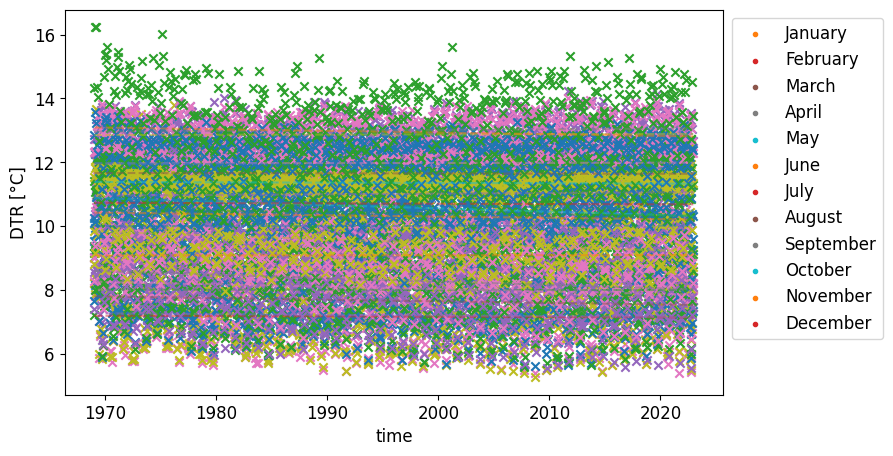

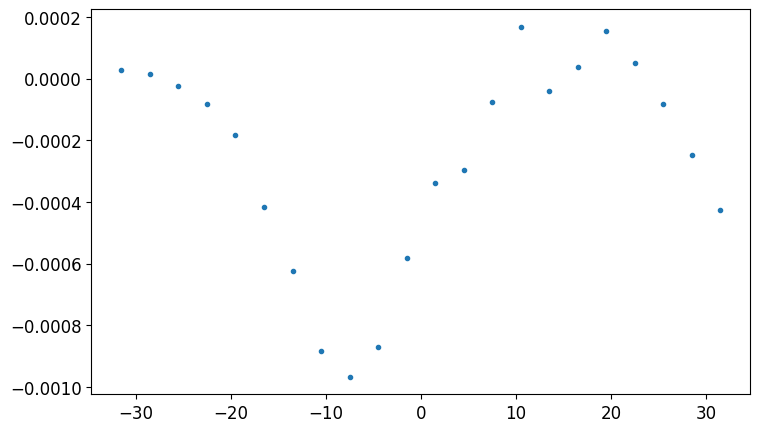

[2.6440988649670344e-05, 1.3532446350132175e-05, -2.3359951830381112e-05, -8.214315752937387e-05, -0.0001832736873723718, -0.0004167441585913171, -0.0006227880349273664, -0.0008834280475004345, -0.0009670606318941037, -0.000872022511205148, -0.0005807734050116903, -0.0003372810008781086, -0.00029641400710075504, -7.632866777066029e-05, 0.0001680318093305715, -3.957084865399265e-05, 3.5968265292865114e-05, 0.00015491352303734058, 5.1967643250005296e-05, -8.181179051001363e-05, -0.00024770913672154124, -0.0004273748015566781]


In [21]:
# Create lists to store legend handles
legend_handles = []

# Create lists to store regression coefficients and R-squared values
regression_coeffs = []
r_squared_values = []

# startdate = pd.to_datetime('1973-01-01')
# enddate = pd.to_datetime('2023-01-01')

for i in list(unique_bins.values):
    #color = legend_colors[i - 1]
    # Filter the data for the specified date range (1960-01-01 to 1980-12-31)
    
    
    x = np.arange(len(DTR_binned_timeseries[str(i)]['time']))  # Use an index as x values
    y = DTR_binned_timeseries[str(i)]

    # Fit a linear regression line
    slope, intercept = np.polyfit(x, y, 1)
    
    # Calculate R-squared
    residuals = y - (slope * x + intercept)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    r_squared = 1 - (ss_res / ss_tot)

    # Plot the scatter plot
    plt.scatter(DTR_binned_timeseries[str(i)]['time'], y, marker='x', label= str(i))
    
    # Plot the regression line
    plt.plot(DTR_binned_timeseries[str(i)]['time'], slope * x + intercept, linestyle='--', alpha  = 0.5)

    # Create a dummy scatter plot with no markers to represent the legend
    legend_handles.append(plt.scatter([], [], marker='.'))

    # Append regression coefficients and R-squared values to lists
    regression_coeffs.append(slope)
    r_squared_values.append(r_squared)

# Show the legend outside the plot
plt.legend(handles=legend_handles, labels=month_label, loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('time')
plt.ylabel('DTR [°C]')

plt.show()

plt.plot(unique_bins.values + d/2, regression_coeffs, ls = '', marker = '.')

plt.show()

print(regression_coeffs)

Reason for this shift may be the sun. The assumption that the diurnal solar cycle is not important does not hold for lower altitudes.